This script is to generate a rough cylinder.
--2025/04/19

env 'gmsh_env' is used

* A square rough profile will be generated first with first and last columns equal to each other. 
* Then the rough profile will be wrapped on a cylinder.
* Later a bending moment and a torch will be applied at a reference point at one side in ABAQUS. 

# Install and import necessary toolbox

In [1]:
import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d
import os
from scipy.spatial import KDTree
import pandas as pd
import time
import sys
import gmsh

In [2]:

cylinder_file_folder = 'C:\\Abaqus_Works\\roughness_simulation\\cylinder'

rough_or_flat = "flat"

file_name_gmsh = f"gmsh_cylinder_{rough_or_flat}.inp"
file_name_abaqus = f"abaqus_cylinder_{rough_or_flat}.inp"
file_name_input_xlsx = f"input_cylinder_{rough_or_flat}.xlsx"

print(file_name_abaqus)
if rough_or_flat == "flat":
    print(f"right on flat")
else:
    print(f"right on rough")

abaqus_cylinder_flat.inp
right on flat


# Determine the size and control points of 2-D spline

*   Define the range of the volume on X-Y plane

    [Smaller size will be cropped form this volume]
*   Define the interval of control points along X and Y axes

    [Denser points will be interpolated by the fitted spline]
*   Define the thickness of the plate
*   Define Ra in unit 'mm'
*   If necessary, the range can be adjusted into [0.1, 0.5] with increment of 0.005.(not necessary any more 2025/02/20)
* By doing this, ***even*** number of structured grids can be achieved (not necessary any more 2025/02/20)


In [4]:
#-------------------------------------------------------------------------------
# Define original size and parameters about the control points
#-------------------------------------------------------------------------------
# define the range for the point series along circumferential direction and height direction
zeta_low_contrl = -0.6 # (mm)
zeta_upp_contrl = +0.6 # (mm)

# Define the interval of control points in the unit of 'mm'
interv_contrl = 0.060 # unit of 'mm' about half of the hatching distance

num_contrl_thet = 40
num_contrl_zeta= round((zeta_upp_contrl - zeta_low_contrl)/interv_contrl) + 1

print(f'The numbers of control points along circum and height directions are {num_contrl_zeta} and {num_contrl_thet} respectively.')

thet_1D_contrl_grid = np.linspace(0, 2 * np.pi, num_contrl_thet, endpoint=False)
zeta_1D_contrl_grid = np.linspace(zeta_low_contrl, zeta_upp_contrl, num_contrl_zeta)
print(f"two shapes are {thet_1D_contrl_grid.shape} and {zeta_1D_contrl_grid.shape}")
print(f'The last value in  of control points is {thet_1D_contrl_grid[-1]} mm')
#-------------------------------------------------------------------------------
# Define the structured grids which should be denser or smaller than control points
#-------------------------------------------------------------------------------
zeta_low_struct = zeta_low_contrl  # (mm)
zeta_upp_struct = zeta_upp_contrl  # (mm)

#-------------------------------------------------------------------------------
# Define radius of the cylinder and roughness Ra in unit of 'mm'
#-------------------------------------------------------------------------------
radius_cylinder = num_contrl_thet*interv_contrl/(np.pi*2.0) # unit of mm


Ra = 0.005      # unit of mm
print(f'The radius of the cylinder and roughness are {radius_cylinder} mm {Ra} mm respectively.')

#-------------------------------------------------------------------------------
# Define the structured grids which should be denser than control points
#-------------------------------------------------------------------------------
# Define the interval of structured grid which is denser than the control points
elem_sub_times = 1.0
interval_basis = 0.004
interva_struct = interval_basis/elem_sub_times #300.0/147.0*0.001/elem_sub_times   #   with unit of 'mm'
print(f"The interval of the structured grids is {interva_struct} mm")

#-------------------------------------------------------------------------------
# Define the element sizes for GMSH meshing
#-------------------------------------------------------------------------------
# mesh size of the characteristic length which will determine the element size
size_elem_fine = interva_struct  # unit of mm
size_elem_rough = 0.024                  # unit of mm
print(f"fine and rough element size are {size_elem_fine} and {size_elem_rough}")

#-------------------------------------------------------------------------------
# Define the Young's moduli and Poisson's ratio and tensile strain amplitude
#-------------------------------------------------------------------------------
# volume young moduli, Poisson's ratio and shear moduli
volume_young_moduli = 121000.0
volume_possion_ratio = 0.308
volume_shear_moduli = volume_young_moduli/(2.0*(1.0 + volume_possion_ratio))

# tensile strain amplitude
nom_stress = 100.0 # unit of MPa
# strain_amp = 0.005
# print(f"The nominal strain is {strain_amp} mm/mm")


The numbers of control points along circum and height directions are 21 and 40 respectively.
two shapes are (40,) and (21,)
The last value in  of control points is 6.126105674500097 mm
The radius of the cylinder and roughness are 0.3819718634205488 mm 0.005 mm respectively.
The interval of the structured grids is 0.004 mm
fine and rough element size are 0.004 and 0.024


* Generate random surface at the control points
* Fit the random control points with spline function
* The number of control points will determines the number of peaks and valleys
* Sampling the dense structured grids with the available spline interpolator



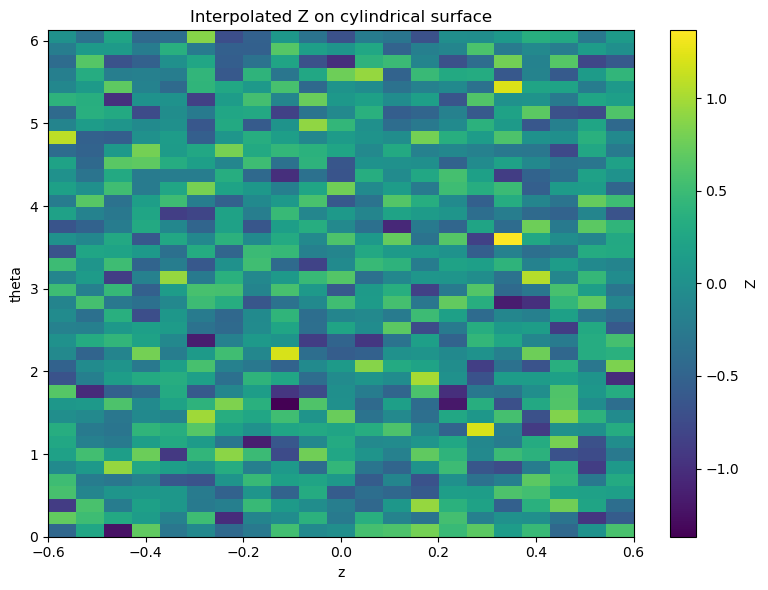

numbers of structured grids along circumferential and height directions is 600 and 301 respectively.
6.27271333166762


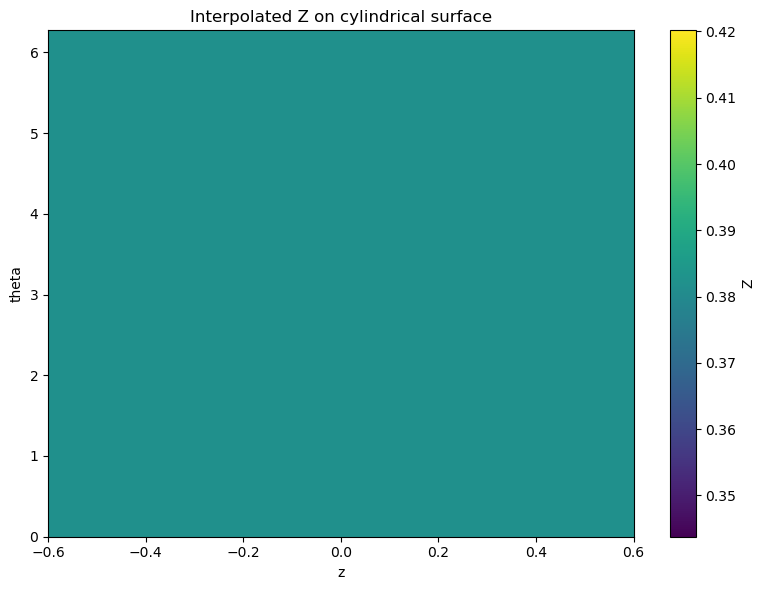

In [ ]:

# Create random values for the control points
"""
                                  negelected 'endpoint=False'
                                  |   
                                  V   
    O----X----+     ...           O
    |    |    |                   | 
    O----X----+     ...           O
    |    |    |                   |   
    .    .    .                   .  
    .    .    .                   . 
    .    .    .                   . 
    |    |    |                   |
    O----X----+     ...           O
   ---------------------------------------> theta (circumferential direction) 

"""
#-------------------------------------------------------------------------------
# Define the range of the structured grids
# Structured grids are not necessary to be overlapped with control points
#-------------------------------------------------------------------------------
#                                                                    |   |   |
#                                                                    |   |   |
#                                                                    V   V   V
thet_2D_contrl_grid, zeta_2D_contrl_grid = np.meshgrid(thet_1D_contrl_grid, zeta_1D_contrl_grid, indexing='ij')


# rand_seed = 143567
np.random.seed()

# * np.exp(-((zeta_1D_contrl_grid)**2)/6)
K_num_freq = num_contrl_thet // 2 
a_k_real = [np.random.randn(num_contrl_zeta) for _ in range(K_num_freq + 1)]
a_k_imag = [np.random.randn(num_contrl_zeta) for _ in range(K_num_freq + 1)]

# Build Z(θ, z)
Ra_2D_contrl_grid_cplx = np.zeros((num_contrl_thet, num_contrl_zeta), dtype=complex)
for k in range(1, K_num_freq + 1):
    # Positive and negative frequencies
    Ra_2D_contrl_grid_cplx += (a_k_real[k] + 1j * a_k_imag[k])[None, :] * np.exp(+1j * k * thet_2D_contrl_grid)
    Ra_2D_contrl_grid_cplx += (a_k_real[k] - 1j * a_k_imag[k])[None, :] * np.exp(-1j * k * thet_2D_contrl_grid)

# Normalize and get real part
Ra_2D_contrl_grid = Ra_2D_contrl_grid_cplx.real / K_num_freq

# Interpolators for each Fourier coefficient in z-direction
interp_real = [interp1d(zeta_1D_contrl_grid, a_k_real[k], kind='cubic', fill_value='extrapolate') for k in range(K_num_freq+1)]
interp_imag = [interp1d(zeta_1D_contrl_grid, a_k_imag[k], kind='cubic', fill_value='extrapolate') for k in range(K_num_freq+1)]

# Plot result
plt.figure(figsize=(8, 6))
plt.imshow(Ra_2D_contrl_grid, extent=[zeta_1D_contrl_grid[0], zeta_1D_contrl_grid[-1], thet_1D_contrl_grid[0], thet_1D_contrl_grid[-1]],
           aspect='auto', origin='lower', cmap='viridis')
plt.xlabel("z")
plt.ylabel("theta")
plt.title("Interpolated Z on cylindrical surface")
plt.colorbar(label="Z")
plt.tight_layout()
plt.show()
#--------------------------------------------------------------------------------------------
# Number of the structured grids along theta- or Z-axes
num_struct_thet = num_contrl_thet*15
num_struct_zeta = round((zeta_upp_struct - zeta_low_struct)/interva_struct) + 1
print(f"numbers of structured grids along circumferential and height directions is {num_struct_thet} and {num_struct_zeta} respectively.")



thet_1D_struct_grid = np.linspace(0, 2 * np.pi, num_struct_thet, endpoint=False)
zeta_1D_struct_grid = np.linspace(zeta_low_contrl, zeta_upp_contrl, num_struct_zeta)
print(thet_1D_struct_grid[-1])

thet_2D_struct_grid, zeta_2D_struct_grid = np.meshgrid(thet_1D_struct_grid, zeta_1D_struct_grid, indexing='ij')

Ra_2D_struct_grid_cmpx = np.zeros((len(thet_1D_struct_grid), len(zeta_1D_struct_grid)), dtype=complex)

for k in range(1, K_num_freq+1):
    a_real = interp_real[k](zeta_1D_struct_grid)  # shape (n_z_dense,)
    a_imag = interp_imag[k](zeta_1D_struct_grid)

    # Add positive and negative frequencies
    Ra_2D_struct_grid_cmpx += (a_real[None, :] + 1j * a_imag[None, :]) * np.exp(+1j * k * thet_2D_struct_grid)
    Ra_2D_struct_grid_cmpx += (a_real[None, :] - 1j * a_imag[None, :]) * np.exp(-1j * k * thet_2D_struct_grid)

# Normalize and take real part
Ra_2D_struct_grid = Ra_2D_struct_grid_cmpx.real / K_num_freq
# del_radi = radi_2D_struct_grid[-1,:] - radi_2D_struct_grid[0, :]
# print(f"del {del_radi}")

mean_Ra_2D_grid = np.mean(Ra_2D_struct_grid)

# shift the surface by mean_surface
shift_mean_Ra_2D_grid = Ra_2D_struct_grid - mean_Ra_2D_grid

# calculate the Ra (or average of the absolute mean)
mean_abs_shift_Ra_2D_grids = np.mean(np.abs(shift_mean_Ra_2D_grid))

Ra_2D_struct_grid = shift_mean_Ra_2D_grid/mean_abs_shift_Ra_2D_grids*Ra

if rough_or_flat == "flat":
    Ra_2D_struct_grid = np.zeros((len(thet_1D_struct_grid), len(zeta_1D_struct_grid)))

radi_2D_struct_grid = Ra_2D_struct_grid + radius_cylinder
# Plot result
plt.figure(figsize=(8, 6))
plt.imshow(radi_2D_struct_grid, extent=[zeta_1D_struct_grid[0], zeta_1D_struct_grid[-1], thet_1D_struct_grid[0], thet_1D_struct_grid[-1]],
           aspect='auto', origin='lower', cmap='viridis')
plt.xlabel("z")
plt.ylabel("theta")
plt.title("Interpolated Z on cylindrical surface")
plt.colorbar(label="Z")
plt.tight_layout()
plt.show()




Setting the square hole size

In [6]:
#----------------------------------
# write the data into the file
#----------------------------------

rough_surface_file_path = os.path.join(cylinder_file_folder, file_name_input_xlsx)

sheet_name_list = ['R']

with pd.ExcelWriter(rough_surface_file_path, engine='openpyxl') as writer:
    # output the R
    sheet_name = f"{sheet_name_list[0]}"
    df = pd.DataFrame(Ra_2D_struct_grid[:, :])
    df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)

# Generate random volume with rough surface

Generate model by GMSH

In [7]:
# Add lines and register them in the dictionary
def add_line(p1, p2, line_lookup):
    # sort the two points according to its number
    if p1 < p2:
        p_A = p1
        p_B = p2
    else:
        p_A = p2
        p_B = p1
    # construct tuple of two points on both sides of a line
    line = (p_A, p_B)
    if line in line_lookup:
        return False
    else:
        tag = len(line_lookup) + 1  # Unique tag
        gmsh.model.occ.addLine(p_A, p_B, tag)
        line_lookup[line] = tag  # Store with sorted points as key
        return True

# Retrieve a line tag by two points and direction
def get_line_tag(p1, p2, line_lookup):
    direction = 0
    if p1 < p2:
        p_A = p1
        p_B = p2
        direction = +1
    else:
        p_A = p2
        p_B = p1
        direction = -1
    line = (p_A, p_B)

    return line_lookup.get(line)*direction

In [8]:

# Initialize gmsh
gmsh.initialize()
gmsh.model.add("rough_surface_with_hole")

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Register points for the rough surface
node_number_outer_surf = 0
node_list =[]
#                                        endpoint=False  |
#                                          |   |   |     |
#                                          V   V   V     V
node_idx_cyli_outer_1the_more = np.zeros((num_struct_thet + 1, num_struct_zeta), dtype=int)

for i in range(num_struct_thet):
    for j in range(num_struct_zeta):

        node_number_outer_surf += 1
        node_idx_cyli_outer_1the_more[i, j] = int(node_number_outer_surf)

        theta = thet_1D_struct_grid[i]
        x = radi_2D_struct_grid[i, j] * np.cos(theta)
        y = radi_2D_struct_grid[i, j] * np.sin(theta)

        #                                        Z in cylindrical coordinate
        #                                        |
        #                                        V
        gmsh.model.occ.add_point( x, y, zeta_1D_struct_grid[j], size_elem_fine, node_number_outer_surf)
        node_list.append(node_number_outer_surf)

# last circumferential coordinate in node_idx_cyli_outer_1the_more will be assigned the the first one column
node_idx_cyli_outer_1the_more[-1, :] = node_idx_cyli_outer_1the_more[0, :]

#------------------------------------------------------------------------------------------------------
# add an internal cylinder hole inside the above one


interv_coarse = size_elem_rough

# times_outer_inner = round(interv_contrl/interv_coarse)
# print(f"times_outer_inner={times_outer_inner}")
# if num_struct_thet % times_outer_inner != 0:
#     print(f"The number of control points along circumferential direction {num_contrl_thet} is not divisible by {times_outer_inner}, please check the input parameters!")
#     sys.exit(0)
print(f"The numbers of struct  points along circumferential and height directions are {num_struct_thet} and {num_struct_zeta} respectively.")

num_coarse_thet = 24
if num_struct_thet % num_coarse_thet != 0:
    print(f"The number of control points along circumferential direction {num_struct_thet} is not divisible by {num_coarse_thet}, please check the input parameters!")
    sys.exit(0)
times_outer_inner = round(num_struct_thet/num_coarse_thet)
num_coarse_zeta = round((zeta_upp_contrl - zeta_low_contrl)/interv_coarse) + 1
print(f'The numbers of coarse points along circum and height directions are {num_coarse_thet} and {num_coarse_zeta} respectively.')

radius_hole = num_coarse_thet*interv_coarse/(np.pi*2.0) # unit of mm
print(f'The radius of the hole and outer is {radius_hole} and {radius_cylinder} mm')

if radius_cylinder < 1.5*radius_hole:
    sys.exit("The radius of the cylinder is smaller than the inner hole, please check the input parameters!")

thet_1D_coarse_grid = np.linspace(0, 2 * np.pi, num_coarse_thet, endpoint=False)
zeta_1D_coarse_grid = np.linspace(zeta_low_contrl, zeta_upp_contrl, num_coarse_zeta)
node_number_inner_surf = node_number_outer_surf
#                                        endpoint=False  |
#                                          |   |   |     |
#                                          V   V   V     V
node_idx_cyli_inner_1the_more = np.zeros((num_coarse_thet + 1, num_coarse_zeta), dtype=int)

for i in range(num_coarse_thet):
    for j in range(num_coarse_zeta):

        node_number_inner_surf += 1
        node_idx_cyli_inner_1the_more[i, j] = int(node_number_inner_surf)

        theta = thet_1D_coarse_grid[i]
        x = radius_hole * np.cos(theta)
        y = radius_hole * np.sin(theta)

        #                                        Z in cylindrical coordinate
        #                                        |
        #                                        V
        gmsh.model.occ.add_point( x, y, zeta_1D_coarse_grid[j], size_elem_rough, node_number_inner_surf)
        node_list.append(node_number_inner_surf)

# last circumferential coordinate in node_idx_cyli_outer_1the_more will be assigned the the first one column
node_idx_cyli_inner_1the_more[-1, :] = node_idx_cyli_inner_1the_more[0, :]

# add a few more points along the cylindrical axis

# num_elems_axis = round((zeta_upp_struct - zeta_low_struct)/num_contrl_zeta) + 1

# for i in range(num_elems_axis):

#     zeta = zeta_low_struct + i * num_contrl_zeta
#     gmsh.model.occ.add_point(0.0, 0.0, zeta, size_elem_rough, node_number_outer_surf+i+1)
#     node_list.append(node_number_outer_surf+i+1)


The numbers of struct  points along circumferential and height directions are 600 and 301 respectively.
The numbers of coarse points along circum and height directions are 24 and 51 respectively.
The radius of the hole and outer is 0.09167324722093173 and 0.3819718634205488 mm


In [9]:
#-----------------------------------------------------------------------
# register all lines necessary to form the surfaces
# all lines will be used to form the wireframe
#-----------------------------------------------------------------------
"""
 zeta
  ^               [rough cylindrical surface]
  |
  |  p4|         |p3
  |----|---------|-------
  |    | +    2  |
  |    |   +     |
  |    |     +   |
  |    |   1   + |
  |----|---------|-------
  |  p1|         |p2
  |
--|------------------------> theta (circumferential direction)
   two triagular elements

"""
line_lookup = {}
#            node_idx_cyli_outer_1the_more.shape[0] = num_struct_thet + 1
#                   |   |   |
#                   V   V   V
for i in range(num_struct_thet):
    for j in range(num_struct_zeta - 1):

        # extract four points in the grid
        p1 = node_idx_cyli_outer_1the_more[i,    j    ]
        p2 = node_idx_cyli_outer_1the_more[i + 1,j    ]
        p3 = node_idx_cyli_outer_1the_more[i + 1,j + 1]
        p4 = node_idx_cyli_outer_1the_more[i,    j + 1]

        if p1 == 0 or p2 == 0 or p3 == 0 or p4 == 0:
            print(f"Error in the points X=[ {i}, {i+1}] Y=[{j}, {j+1}]")
            sys.error(5)
        # 202504.09
        # seperate the square element into two triangles
        # P1->P2->P4->P1
        add_line(p1, p2, line_lookup)
        add_line(p2, p4, line_lookup)
        add_line(p4, p1, line_lookup)
        # P2->P3->P4->P2
        add_line(p2, p3, line_lookup)
        add_line(p3, p4, line_lookup)
        add_line(p4, p2, line_lookup)
print(f"lines are {len(line_lookup)}")
# add lines for the inner hole
for i in range(num_coarse_thet):
    for j in range(num_coarse_zeta - 1):

        # extract four points in the grid
        p1 = node_idx_cyli_inner_1the_more[i,    j    ]
        p2 = node_idx_cyli_inner_1the_more[i + 1,j    ]
        p3 = node_idx_cyli_inner_1the_more[i + 1,j + 1]
        p4 = node_idx_cyli_inner_1the_more[i,    j + 1]

        if p1 == 0 or p2 == 0 or p3 == 0 or p4 == 0:
            print(f"Error in the points X=[ {i}, {i+1}] Y=[{j}, {j+1}]")
            sys.error(5)
        # 202504.09
        # seperate the square element into two triangles
        # P1->P2->P4->P1
        add_line(p1, p2, line_lookup)
        add_line(p2, p4, line_lookup)
        add_line(p4, p1, line_lookup)
        # P2->P3->P4->P2
        add_line(p2, p3, line_lookup)
        add_line(p3, p4, line_lookup)
        add_line(p4, p2, line_lookup)
print(f"lines are {len(line_lookup)}")

# add lines from the outer circle to the inner inner circle
for i in range(num_coarse_thet):
    # bottom plane
    p1 = node_idx_cyli_inner_1the_more[i,                    0]
    p2 = node_idx_cyli_outer_1the_more[i*times_outer_inner,  0]
    add_line(p1, p2, line_lookup)
    
    # top plane
    p1 = node_idx_cyli_inner_1the_more[i,                   -1]
    p2 = node_idx_cyli_outer_1the_more[i*times_outer_inner, -1]
    add_line(p1, p2, line_lookup)
print(f"lines are {len(line_lookup)}")

lines are 540600
lines are 544224
lines are 544272


In [ ]:
#-----------------------------------------------------------------------
# register closed curves and faces on the rough cylindrical surface
#-----------------------------------------------------------------------
curve_loop_number = 0
face_number_surface = 0
face_list =[]

"""

 zeta
  ^               [rough cylindrical surface]
  |
  |  p4|         |p3
  |----|---------|-------
  |    | +    2  |
  |    |   +     |
  |    |     +   |
  |    |   1   + |
  |----|---------|-------
  |  p1|         |p2
  |
--|------------------------> theta (circumferential direction)
   two triagular elements

"""
print(f"The shape of node_idx_cyli_outer_1the_more is {node_idx_cyli_outer_1the_more.shape}")
print(f"num_struct_thet={num_struct_thet} num_struct_zeta={num_struct_zeta}")

"""
    Outer surface of the cylinder
"""
#            node_idx_cyli_outer_1the_more.shape[0] = num_struct_thet + 1
#                            |
#                            V
for i in range(num_struct_thet):
    for j in range(num_struct_zeta - 1):
        
        # extract four points in the grid
        p1 = node_idx_cyli_outer_1the_more[i,     j    ]
        p2 = node_idx_cyli_outer_1the_more[i + 1, j    ]
        p3 = node_idx_cyli_outer_1the_more[i + 1, j + 1]
        p4 = node_idx_cyli_outer_1the_more[i,     j + 1]
        # print(f"i={i} j={j} at {p1} {p2} {p3} {p4}")
        # 2025.04.09
        # seperate the square element into two triangles
        # P1->P2->P4->P1
        line_1_2 = get_line_tag(p1, p2, line_lookup)
        line_2_4 = get_line_tag(p2, p4, line_lookup)
        line_4_1 = get_line_tag(p4, p1, line_lookup)
        curve_loop_number += 1  # the tag of the closed curve
        # print(f"curveloop={curve_loop_number},{line_1_2},{line_2_4},{line_4_1}")
        curve_loop_tag = gmsh.model.occ.addCurveLoop([line_1_2, line_2_4, line_4_1])
        face_number_surface += 1
        gmsh.model.occ.addPlaneSurface([curve_loop_tag], face_number_surface)
        face_list.append(face_number_surface)

        # P1->P2->P4->P1
        line_2_3 = get_line_tag(p2, p3, line_lookup)
        line_3_4 = get_line_tag(p3, p4, line_lookup)
        line_4_2 = get_line_tag(p4, p2, line_lookup)
        curve_loop_number += 1  # the tag of the closed curve
        # print(f"curveloop={curve_loop_number},{line_2_3},{line_3_4},{line_4_2}")
        curve_loop_tag = gmsh.model.occ.addCurveLoop([line_2_3, line_3_4, line_4_2])
        face_number_surface += 1
        gmsh.model.occ.addPlaneSurface([curve_loop_tag], face_number_surface)
        face_list.append(face_number_surface)

"""
    Inner surface of the cylinder
"""
#            node_idx_cyli_inner_1the_more.shape[0] = num_coarse_thet + 1
#                            |
#                            V
for i in range(num_coarse_thet):
    for j in range(num_coarse_zeta - 1):
        
        # extract four points in the grid
        p1 = node_idx_cyli_inner_1the_more[i,     j    ]
        p2 = node_idx_cyli_inner_1the_more[i + 1, j    ]
        p3 = node_idx_cyli_inner_1the_more[i + 1, j + 1]
        p4 = node_idx_cyli_inner_1the_more[i,     j + 1]
        # print(f"i={i} j={j} at {p1} {p2} {p3} {p4}")
        # 2025.04.09
        # seperate the square element into two triangles
        # P1->P2->P4->P1
        line_1_2 = get_line_tag(p1, p2, line_lookup)
        line_2_4 = get_line_tag(p2, p4, line_lookup)
        line_4_1 = get_line_tag(p4, p1, line_lookup)
        curve_loop_number += 1  # the tag of the closed curve
        # print(f"curveloop={curve_loop_number},{line_1_2},{line_2_4},{line_4_1}")
        curve_loop_tag = gmsh.model.occ.addCurveLoop([line_1_2, line_2_4, line_4_1])
        face_number_surface += 1
        gmsh.model.occ.addPlaneSurface([curve_loop_tag], face_number_surface)
        face_list.append(face_number_surface)

        # P1->P2->P4->P1
        line_2_3 = get_line_tag(p2, p3, line_lookup)
        line_3_4 = get_line_tag(p3, p4, line_lookup)
        line_4_2 = get_line_tag(p4, p2, line_lookup)
        curve_loop_number += 1  # the tag of the closed curve
        # print(f"curveloop={curve_loop_number},{line_2_3},{line_3_4},{line_4_2}")
        curve_loop_tag = gmsh.model.occ.addCurveLoop([line_2_3, line_3_4, line_4_2])
        face_number_surface += 1
        gmsh.model.occ.addPlaneSurface([curve_loop_tag], face_number_surface)
        face_list.append(face_number_surface)

"""
    bottom plane of the cylinder with a hole
"""

for i in range(num_coarse_thet):
    line_list_face = []
    # print(f"i={i}")
    p1 = node_idx_cyli_inner_1the_more[i,   0]
    p2 = node_idx_cyli_inner_1the_more[i+1, 0]
    line = get_line_tag(p1, p2, line_lookup)
    line_list_face.append(line)
    # print(f"p1={p1} p2={p2}")
    p1 = node_idx_cyli_inner_1the_more[i+1, 0]
    p2 = node_idx_cyli_outer_1the_more[(i+1)*times_outer_inner, 0]
    line = get_line_tag(p1, p2, line_lookup)
    line_list_face.append(line)
    # print(f"p1={p1} p2={p2}")
    
    for j in range((i+1)*times_outer_inner, i*times_outer_inner, -1):
        p1 = node_idx_cyli_outer_1the_more[j, 0]
        p2 = node_idx_cyli_outer_1the_more[j-1, 0]
        line = get_line_tag(p1, p2, line_lookup)
        line_list_face.append(line)
        # print(f"j={j} p1={p1} p2={p2}")
    
    p1 = node_idx_cyli_outer_1the_more[i*times_outer_inner, 0]
    p2 = node_idx_cyli_inner_1the_more[i,   0]
    line = get_line_tag(p1, p2, line_lookup)
    line_list_face.append(line)
    # print(f"p1={p1} p2={p2}")
    curve_loop_tag = gmsh.model.occ.addCurveLoop(line_list_face)
    face_number_surface += 1
    gmsh.model.occ.addPlaneSurface([curve_loop_tag], face_number_surface)
    face_list.append(face_number_surface)


"""
    top plane of the cylinder with a hole
"""

for i in range(num_coarse_thet):
    line_list_face = []
    p1 = node_idx_cyli_inner_1the_more[i,   -1]
    p2 = node_idx_cyli_inner_1the_more[i+1, -1]
    line = get_line_tag(p1, p2, line_lookup)
    line_list_face.append(line)

    p1 = node_idx_cyli_inner_1the_more[i+1, -1]
    p2 = node_idx_cyli_outer_1the_more[(i+1)*times_outer_inner, -1]
    line = get_line_tag(p1, p2, line_lookup)
    line_list_face.append(line)

    for j in range((i+1)*times_outer_inner,times_outer_inner*i, -1):
        p1 = node_idx_cyli_outer_1the_more[j, -1]
        p2 = node_idx_cyli_outer_1the_more[j-1, -1]
        line = get_line_tag(p1, p2, line_lookup)
        line_list_face.append(line)
    
    p1 = node_idx_cyli_outer_1the_more[i*times_outer_inner, -1]
    p2 = node_idx_cyli_inner_1the_more[i,   -1]
    line = get_line_tag(p1, p2, line_lookup)
    line_list_face.append(line)

    curve_loop_tag = gmsh.model.occ.addCurveLoop(line_list_face)
    face_number_surface += 1
    gmsh.model.occ.addPlaneSurface([curve_loop_tag], face_number_surface)
    face_list.append(face_number_surface)

#-----------------------------------------------------------------------
# generate mesh according to the registered entities
#-----------------------------------------------------------------------
# Create the relevant Gmsh data structures from Gmsh model.
gmsh.model.occ.addSurfaceLoop(face_list, 1)
gmsh.model.occ.addVolume([1])

# Synchronize again after Boolean operation
# gmsh.model.occ.synchronize()

The shape of node_idx_cyli_outer_1the_more is (601, 301)
num_struct_thet=600 num_struct_zeta=301


In [12]:
# print(f"{len(face_list)}")
# node_tags = [pt[1] for pt in gmsh.model.getEntities(dim=0)]  # All points
# gmsh.model.mesh.field.add("Distance", 1)
# gmsh.model.mesh.field.setNumbers(1, "FacesList", face_list)  # or use "EdgesList" or "NodesList"
# # gmsh.model.mesh.field.setNumbers(1, "NodesList", node_tags)  # or use "EdgesList" or "NodesList"

# fine_size = 0.01
# coarse_size = 0.1
# d_min = 0.0       # right at surface
# d_max = 0.02      # start coarse elements from this depth inward

# gmsh.model.mesh.field.add("Threshold", 2)
# gmsh.model.mesh.field.setNumber(2, "InField", 1)  # Distance field
# gmsh.model.mesh.field.setNumber(2, "SizeMin", size_elem_fine)
# gmsh.model.mesh.field.setNumber(2, "SizeMax", size_elem_rough)
# gmsh.model.mesh.field.setNumber(2, "DistMin", d_min)  # up to this distance, use fine_size
# gmsh.model.mesh.field.setNumber(2, "DistMax", d_max)  # after this distance, use coarse_size

# gmsh.model.mesh.field.setAsBackgroundMesh(2)


In [13]:
gmsh.option.setNumber("Mesh.Optimize", 1)  # 启用优化器
gmsh.option.setNumber("Mesh.OptimizeNetgen", 1)  # 启用 Netgen 优化
gmsh.option.setNumber("Mesh.QualityType", 2)  # 设置网格质量类型为最小雅可比值
gmsh.option.setNumber("Mesh.Smoothing", 2)  # 平滑操作次数
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.001)  # 最小单元大小
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", size_elem_rough)   # 最大单元大小
# gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0)  # same as Threshold SizeMin
# gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 1E9)  # same as Threshold SizeMax
gmsh.model.occ.synchronize()
gmsh.model.mesh.generate(3)

# Remove 1D elements
line_tags = gmsh.model.getEntities(dim=1)
for dim, tag in line_tags:
    gmsh.model.removeEntities([(dim, tag)], recursive=True)

# face_tags = gmsh.model.getEntities(dim=2)
# for dim, tag in face_tags:
#     gmsh.model.removeEntities([(dim, tag)], recursive=True)

# gmsh.model.occ.synchronize()
# Save the mesh to a file
file_gmsh_path = os.path.join(cylinder_file_folder, file_name_gmsh)
gmsh.write(file_gmsh_path)
gmsh.finalize()

# Generate ABAQUS 'inp' file

Parse the node and element sections from GMSH generated 'inp' file


In [14]:
def parse_nodes(lines):
    """
    Parse the node data from the input file.
    This assumes the node data starts with "*NODE" and contains node definitions.
    """
    nodes = []
    in_nodes_section = False
    for line in lines:
        line = line.upper() # convert the string into uppercase

        if len(line) > 1 and line.startswith('**'):
            continue

        if line.startswith('*NODE'):
            in_nodes_section = True
        elif in_nodes_section:
            if line.startswith('*'):
                in_nodes_section = False
                break  # End of nodes section
            node_data = list(map(float, line.split(',')))
            nodes.append(node_data[1:]) # node number is not included because they are already sorted.

    return nodes


Parse the volume and surface elements from GMSH generated 'inp' file


In [15]:
def parse_elements(lines):
    """
    Parse the element data from the input file.
    This assumes the element data starts with "*ELEMENT" and contains node definitions.
    The first integer is the element number
    """
    elements_volume = []
    elements_surface = []
    elements_line = []

    in_elements_section = False

    line_element = False
    surface_element = False
    volume_element = False
    
    index_volume_element = 0

    for line in lines:
        line = line.upper() # convert the string into uppercase

        if len(line) > 1 and line.startswith('**'):
            continue

        if line.startswith('*ELEMENT'):
            in_elements_section = True
            if 'T3D2' in line:
                line_element = True
                surface_element = False
                volume_element = False
            if 'CPS3' in line:
                line_element = False
                surface_element = True
                volume_element = False
            if 'C3D4' in line:
                line_element = False
                surface_element = False
                volume_element = True

        elif in_elements_section:
            if line.startswith('*'):
                in_elements_section = False
                break  # End of elements section
            element_data = list(map(int, line.split(',')))
            
            if volume_element:
                index_volume_element += 1
                element_data[0] = index_volume_element
                elements_volume.append(element_data[:])   # element number is included
            if surface_element:
                elements_surface.append(element_data[:])   # element number is included
            if line_element:
                elements_line.append(element_data[:])

    return elements_volume, elements_surface

Exclude the surface elements on four vertical plane and bottom plane so that only surface elements on top will be saved

In [16]:
def parse_cylindrical_surface_elements(elements_surface, nodes):
    """
     Differentiate the CPS3 elements into six sets (bottom, left, right, front, back, top-rough)
     Now there is a square hole in the center
    """

    tol = 1E-6

    elements_cylindrical_surface = []

    # loop through each element
    for element in elements_surface:

        x = [nodes[node_number-1][0] for node_number in element[1:]]
        y = [nodes[node_number-1][1] for node_number in element[1:]]
        z = [nodes[node_number-1][2] for node_number in element[1:]]

        rad = np.sqrt(np.array(x)**2 + np.array(y)**2)

        
        if abs(max(z) - min(z)) < tol:
            # triangle element on the surface
            continue 
        elif abs(max(rad)) < (radius_hole + 5E-2):
            # triangle element on the inner surface
            continue
        else:
            # triangle element on the outer surface
            elements_cylindrical_surface.append(element)

    return elements_cylindrical_surface

Write ABAQUS inp file according to its format

In [17]:
def write_numbers_with_increment(list_of_integer, increment, file):
    # 16 items per line
    for i in range(0, len(list_of_integer), increment):
        # retrieve certain amount of items
        chunk = list_of_integer[i:i + increment]
        # seperate the items by comma
        file.write(",".join(map(str, chunk)) + "\n")

def write_inp_file(nodes_volume, elements_volume, nodes_free_volume_cylindrical_surface,
            nodes_volume_top, nodes_volume_bot, file_name_abaqus):
    

    #-----------------------------------------------------------------------
    #   find the structured nodes on the top surface of the volume 
    #   and aggregate them into a node set
    #-----------------------------------------------------------------------    
    nodes_free_cylindrical_surface = []
    for node_id in nodes_free_volume_cylindrical_surface:
        node = nodes_volume[node_id-1]
        loc_rad = np.sqrt(node[0]**2 + node[1]**2)
        x = node[0]/loc_rad*radius_cylinder
        y = node[1]/loc_rad*radius_cylinder
        nodes_free_cylindrical_surface.append([x, y, node[2]])

    nodes_free_cylindrical_surface = np.array(nodes_free_cylindrical_surface)
    tree = KDTree(nodes_free_cylindrical_surface)

     # create nodes list for the structured grid points on cylindrical surface
    nodes_struct_grids_cylindrical_surface = []
    for row in range(0, num_struct_thet, 1):
        for col in range(0, num_struct_zeta, 1):

            theta = thet_1D_struct_grid[row]
            x = radius_cylinder * np.cos(theta)
            y = radius_cylinder * np.sin(theta)
            
            node_struct = [x, y, zeta_1D_struct_grid[col]]
            nodes_struct_grids_cylindrical_surface.append(node_struct)
    
    # register the structured grids to the nodes in the free mesh
    nodes_struct_volume_cylindrical_surface = []
    for idx_struct, node_struct in enumerate(nodes_struct_grids_cylindrical_surface):
        dist, idx_free = tree.query([node_struct])
        if idx_free is None or len(idx_free) == 0 or dist > 1E-3:
            print(f"KDTree query failed for node {node_struct} and distance {dist}")
            continue
        nodes_struct_volume_cylindrical_surface.append(nodes_free_volume_cylindrical_surface[idx_free[0]])

    print(f"{len(nodes_struct_volume_cylindrical_surface)} nodes are registered to the struct grid")
    with open(file_name_abaqus, 'w') as file:
        #---------------------------------------------------------------
        # *Heading and Preprint
        #---------------------------------------------------------------
        # write *Heading and *Preprent
        file.write('*Heading\n')
        file.write(f'**Job name: {file_name_abaqus}\n')
        file.write('*Preprint, echo=NO, model=NO, history=NO, contact=NO\n')
        file.write('**\n')

        #---------------------------------------------------------------
        # *PART Volume
        #---------------------------------------------------------------
        # writing volume part: C3D4 elements
        part_volume = 'VOLUME'
        file.write(f'*Part, name={part_volume}\n')

        # Node
        file.write('*Node\n')
        for index_node, node in enumerate(nodes_volume):
            file.write(f'{index_node + 1}, {node[0]:.9f}, {node[1]:.9f}, {node[2]:.9f}\n')

        # Element
        file.write('*Element, Type=C3D4\n')
        for element in elements_volume:
            file.write(f'{element[0]}, {element[1]}, {element[2]}, {element[3]}, {element[4]}\n')

        # node set at structured grids on the top surface
        nset_struct_volume_surface = 'F_VOL_SURF_STRUCT'
        file.write(f'*Nset, nset={nset_struct_volume_surface}\n')
        write_numbers_with_increment(nodes_struct_volume_cylindrical_surface, 16, file)

         # node set at structured grids on the top surface
        nset_free_volume_surface = 'F_VOL_SURF_FREE'
        file.write(f'*Nset, nset={nset_free_volume_surface}\n')
        write_numbers_with_increment(nodes_free_volume_cylindrical_surface, 16, file)

        # node set at structured grids on the top surface
        nset_volume_top_plane = 'F_VOL_TOP'
        file.write(f'*Nset, nset={nset_volume_top_plane}\n')
        write_numbers_with_increment(nodes_volume_top, 16, file)

        # node set at structured grids on the bottom surface
        nset_volume_bot_plane = 'F_VOL_BOT'
        file.write(f'*Nset, nset={nset_volume_bot_plane}\n')
        write_numbers_with_increment(nodes_volume_bot, 16, file)
        
        # define element set for the volume
        elset_volume = 'SET_VOLUME_SECT'
        file.write(f'*Elset, elset={elset_volume}, generate\n')
        file.write(f'1, {len(elements_volume)}, 1\n')

        # define section for the volume
        material_volume = 'VOLUME_ELAS'
        file.write(f'*Solid Section, elset={elset_volume}, material={material_volume}\n')
        file.write(f',\n')

        # end part volume
        file.write('*End Part\n')

        #---------------------------------------------------------------
        # Assembly
        #---------------------------------------------------------------
        file.write('*Assembly, name=Assembly\n')
        file.write(f'*Instance, name={part_volume+"-1"}, part={part_volume}\n')
        file.write('*End Instance\n')

        # node sets for boundary conditions
        nset_z_negative_face = 'F_Z0'
        nset_z_positive_face = 'F_Z1'
  
        file.write(f'*Nset, nset={nset_z_negative_face}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_bot, 16, file)

        file.write(f'*Nset, nset={nset_z_positive_face}, instance={part_volume+"-1"}\n')
        write_numbers_with_increment(nodes_volume_top, 16, file)

        file.write('*End Assembly\n')

        #---------------------------------------------------------------
        # define two materials
        #---------------------------------------------------------------

        file.write(f"*Material, name={material_volume}\n")
        file.write("*Elastic\n")
        file.write(f"{volume_young_moduli}, {volume_possion_ratio}\n")

        #---------------------------------------------------------------
        # Define STEP-X uniform tensile strain along X axis
        #---------------------------------------------------------------
        step_x = 'TENSILE_X'
        file.write(f"*Step, name={step_x}, nlgeom=NO\n")
        file.write("*Static\n")
        file.write("1., 1., 1e-05, 1.\n")
        file.write("**\n")
        #
        # Define boundary conditions
        #
        # strain amplitude
        strain_z = nom_stress/volume_young_moduli
        disp_z = strain_z * (zeta_1D_struct_grid[-1] - zeta_1D_struct_grid[0])
        
        bend_momt_x = 0.005

        file.write(f"** boundary conditions\n")
        file.write("*Boundary, op=NEW\n")
        
        # F-Z=0
        file.write(f"{nset_z_negative_face}, 1, 1\n")
        file.write(f"{nset_z_negative_face}, 2, 2\n")
        for id_node in nodes_volume_bot:
            #                                        Y-axis
            #                                        V    V              
            disp = -bend_momt_x*nodes_volume[id_node-1][1]
            file.write(f"{part_volume+'-1.'+str(id_node)}, 3, 3, {disp}\n")
        # file.write(f"{nset_z_negative_face}, 3, 3\n")

        # F-Z=1
        file.write(f"{nset_z_positive_face}, 1, 1\n")
        file.write(f"{nset_z_positive_face}, 2, 2\n")
        
        for id_node in nodes_volume_top:
            #                                        Y-axis
            #                                        V    V              
            disp = bend_momt_x*nodes_volume[id_node-1][1]
            file.write(f"{part_volume+'-1.'+str(id_node)}, 3, 3, {disp}\n")

        # file.write(f"{nset_z_positive_face}, 3, 3, {disp_z}\n")

        file.write("*Restart, write, frequency=0\n")

        # output all the necessary variables
        file.write("*Output, field, variable=PRESELECT\n")
        file.write("*Output, history, variable=PRESELECT\n")

        # End step
        file.write("*End Step\n")

        # finish writing inp file
        print(f'INP file has been written to {file_name_abaqus}')


In [18]:
def generate_abaqus_inp_file(file_name_gmsh):
    #-----------------------------------------------------------------------
    # Read the Abaqus input file and return the content as a list of strings.
    #-----------------------------------------------------------------------
    with open(file_name_gmsh, 'r') as file:
        lines = file.readlines()

    #-----------------------------------------------------------------------
    # Parse nodes and volume and surface elements
    #-----------------------------------------------------------------------
    nodes_volume = parse_nodes(lines)
    elements_volume, elements_surface = parse_elements(lines)

    #-----------------------------------------------------------------------
    # finds the nodes on top and bottom
    #-----------------------------------------------------------------------
    z0 = zeta_1D_struct_grid[0]
    z1 = zeta_1D_struct_grid[-1]

    # extract node set in volume for applying boundary conditions
    tol = 1E-6

    nodes_volume_top = []
    nodes_volume_bot = []

    for index, node in enumerate(nodes_volume):
        X, Y, Z = node[0], node[1], node[2]
        if abs(Z - z0) < tol:
            nodes_volume_top.append(index + 1)
            continue
        if abs(Z - z1) < tol:
            nodes_volume_bot.append(index + 1)
            continue
            
    #-----------------------------------------------------------------------
    # find the surface elements on the top rough surface
    #-----------------------------------------------------------------------
    elements_cylindrical_surface = parse_cylindrical_surface_elements(elements_surface, nodes_volume)
    # print(len(elements_cylindrical_surface))

    #-----------------------------------------------------------------------
    # find the nodes on the top surface and elements attached to the top surface
    #-----------------------------------------------------------------------
    nodes_set_cylindrical_surface = set()  # use set to accelerate the set
    # form the node set from surface cps3 elements without duplicated node
    for element in elements_cylindrical_surface:
        nodes_set_cylindrical_surface.update(element[1:])  # update the set

    nodes_free_volume_cylindrical_surface = list(nodes_set_cylindrical_surface)
    print(f"{len(nodes_free_volume_cylindrical_surface)} free nodes on the rough surface")
    #-----------------------------------------------------------------------
    # write abaqus inp file and download it
    #-----------------------------------------------------------------------

    # write inp file
    abaqus_inp_file_path = os.path.join(cylinder_file_folder, file_name_abaqus)

    write_inp_file(nodes_volume, elements_volume, nodes_free_volume_cylindrical_surface,
            nodes_volume_top, nodes_volume_bot, abaqus_inp_file_path)

    # delete the gmsh file
    # if os.path.exists(file_name_gmsh):
    #     os.remove(file_name_gmsh)
    #     print(f"File {file_name_gmsh} has been deleted.")


Parse the node and element sections from GMSH generated 'inp' file


In [19]:
# generate inp for ABAQUS computation
generate_abaqus_inp_file(file_gmsh_path)

360600 free nodes on the rough surface
180600 nodes are registered to the struct grid
INP file has been written to C:\Abaqus_Works\roughness_simulation\cylinder\abaqus_cylinder_flat.inp
